In [1]:
import os
import json
import cv2
from tqdm import tqdm

import torch
import random
import numpy as np
from matplotlib import pyplot as plt
from pose_data import PoseGraph
from training import Trainer
from torch.utils.data import DataLoader

In [2]:
#from gpec_models.gcae import GCAE
from nf_models.model_pose import STG_NF
from nf_models.graph import Graph
#model.load_state_dict(torch.load('checkpoints/ShanghaiTech_85_9.tar')['state_dict'])
from vae import VAE, vae_loss, ae_loss

In [3]:
def stg_nf_loss(z,nll):
    return {'loss': torch.mean(nll)}
    

In [4]:
#83 , 1.21 sec/itr

In [5]:
args = {
'no_of_files' : 107,
'channel'     : 2,
'seg_len'     : 24,
'no_of_kps'   : 18,
'seg_stride'  : 1,
'seg_conf_thr': 0,
'seed'        : 0,
'device'      : 'cuda:0',
'vid_res'     : [856, 480],
'json_dir'    : {
    'train' : '/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/pose/train', 
    'valid' : '/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/pose/test' 
},
'gt_dir'      : {
    'valid'    :
    {
    'mask_dir'  : '/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/gt/test/test_frame_mask/',
    'frame_dir' : '/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/gt/test/frames/'
    },
    'train'    :
    {
    'mask_dir'  : '/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/gt/train/train_frame_mask/',
    'frame_dir' : '/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/train/frames/'
    }
}
}

train_dataset = PoseGraph(args,split='train')
valid_dataset = PoseGraph(args,split='valid')
train_loader  = DataLoader(train_dataset,128)
val_loader    = DataLoader(valid_dataset,256)

#model = GCAE(in_channels=3)
#model = VAE(args,2,128,hidden_dims=[2,4,8,16])#[24,48,96,192]
model = STG_NF()
trainer = Trainer(model,
                  train_loader,
                  val_loader,
                  loss_func= stg_nf_loss,#ae_loss,#model.loss_function,
                  epochs = 5,
                  lr= 0.00001)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:09<00:00, 11.82it/s]


In [ ]:
trainer.train()

In [6]:
ckpt = torch.load('checkpoints/ShanghaiTech_85_9.tar')
model.set_actnorm_init()
model.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [ ]:
model.load_state_dict(torch.load('Jan29_2220__checkpoint.pth.tar')['state_dict'])

In [ ]:
#score = trainer.test()

In [7]:
def test(loader):
    device='cuda:0'
    model.eval()
    model.to(device)
    pbar  = tqdm(loader)
    probs = torch.empty(0).to(device)
    mu   = torch.empty(0).to(device)
    std  = torch.empty(0).to(device)
    results = []
    print("Starting Test Eval")
    for itern, data_arr in enumerate(pbar):
        data_arr = [elem.to(device, non_blocking=True) for elem in data_arr]
        data     = data_arr[0].permute(0,3,1,2)
        scr      = data_arr[2].amin(dim=-1)
        with torch.no_grad():
            z = model(data[:,:2,:,:],label=torch.ones((data.shape[0])),score=scr)
            scores = z[1]#torch.abs(z[0][:,:2] - z[1][:,:2]).mean(dim=[1,2,3])
        
        probs = torch.cat([probs, scores], dim=0)
        #mu  = torch.cat([mu, torch.abs(z[2])], dim=0)
        #std = torch.cat([std, torch.abs(z[3])], dim=0)
        results.append(z)
        
    prob_mat_np = probs.cpu().detach().numpy().squeeze().copy(order='C')
    mu  = mu.cpu().detach().numpy()#.squeeze().copy(order='C')
    std = std.cpu().detach().numpy()#.squeeze().copy(order='C')
    
    return prob_mat_np, mu, std, results

from sklearn.metrics import roc_auc_score

def score_auc(scores_np, gt):
        scores_np[scores_np == np.inf] = scores_np[scores_np != np.inf].max()
        scores_np[scores_np == -1 * np.inf] = scores_np[scores_np != -1 * np.inf].min()
        auc = roc_auc_score(gt, scores_np)
        return auc

In [8]:
score, mu, std, res = test(train_loader)

  0%|                                                                                                                                                                             | 0/1796 [00:00<?, ?it/s]

Starting Test Eval


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1796/1796 [00:38<00:00, 46.88it/s]


In [9]:
tscore, tmu, tstd, tres = test(val_loader)

  1%|▉                                                                                                                                                                     | 3/530 [00:00<00:24, 21.94it/s]

Starting Test Eval


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [00:17<00:00, 30.09it/s]


In [10]:
from sklearn.cluster import KMeans

In [11]:
mu  = score[:,None]
tmu = tscore[:,None]

In [12]:
kmn = KMeans(n_clusters=1,random_state=0)

In [13]:
kmn.fit(mu)

/home/irfan/Desktop/Code/Linux-IO/python_38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=1, random_state=0)

In [14]:
from score import Score
from scipy.ndimage import gaussian_filter1d
import os
files = os.listdir('/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/gt/test/test_frame_mask/')
res1=[]; res2=[];res3=[]
thr=10.0
preds = []
gts   = []
for file in files:
    scr = Score(path='/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/gt/test/test_frame_mask/')
    #res = scr.score_dataset(np.uint8(score>thr),valid_dataset.meta_data)
    try:
        gt,pred,dist = scr.get_clip_score(tscore,tmu,kmn, file, valid_dataset.meta_data)
        _pred = gaussian_filter1d(pred,sigma=7)
        _dist = gaussian_filter1d(dist,sigma=7)
        preds.append(_pred)
        gts.append(gt)
    except:
        print(file)
        continue
    
    
    
    #_dist = _dist/_dist.max()
    try    : res1.append(roc_auc_score(gt,_pred))
    except : res1.append(0)
    '''
    #res2.append(dist)
    fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(10,3))
    axes[0,0].plot(gt);axes[0,0].set_title(str(res1[-1])+f"{file.split('/')[-1]}")
    axes[0,1].plot(np.uint8(_pred>thr))#;axes[0,1].set_ylim(0,1.0)
    axes[0,1].plot(_pred,alpha=0.1)
    axes[0,2].plot(_dist);axes[0,2].set_ylim(0,2.2)
    axes[1,0].plot(gt)
    axes[1,0].plot(np.uint8(_pred>thr))
    axes[1,0].plot(_dist)
    ppp
    gt,pred = scr.get_clip_score(mu, file, valid_dataset.meta_data)
    _pred = gaussian_filter1d(pred,sigma=3)
    res2.append(roc_auc_score(gt,np.uint8(_pred>0.15)))
    axes[1,0].plot(gt)
    axes[1,1].plot(_pred);axes[1,1].set_ylim(0,0.8)
    axes[1,2].plot(pred)

    gt,pred = scr.get_clip_score(std, file, valid_dataset.meta_data)
    _pred = gaussian_filter1d(pred,sigma=3)
    res3.append(roc_auc_score(gt,np.uint8(_pred>0.15)))
    axes[2,0].plot(gt)
    axes[2,1].plot(_pred);axes[1,1].set_ylim(0,0.8)
    axes[2,2].plot(pred)
    '''
    
plt.close()

06_0144.npy
06_0145.npy
01_0130.npy
01_0135.npy
01_0136.npy
12_0152.npy


In [15]:
len(preds),len(gts)

(101, 101)

In [16]:
import pickle
np.save('../tscore_1.npy',tscore)

In [17]:
np.save('../test_samp_1.npy',valid_dataset.__getitem__(1000)[0])

In [18]:
preds_all = np.concatenate(preds)
gts_all   = np.concatenate(gts)

In [19]:
preds_all[preds_all==0]=0
roc_auc_score(gts_all,preds_all)

0.8457385332740401

In [19]:
preds_all.min()

0.0

In [20]:
preds_all[preds_all != -np.inf].min()

0.0

In [35]:
gt,pred,dist = scr.get_clip_score(tscore,tmu,kmn, files[3], valid_dataset.meta_data)
_pred = gaussian_filter1d(pred,sigma=7)

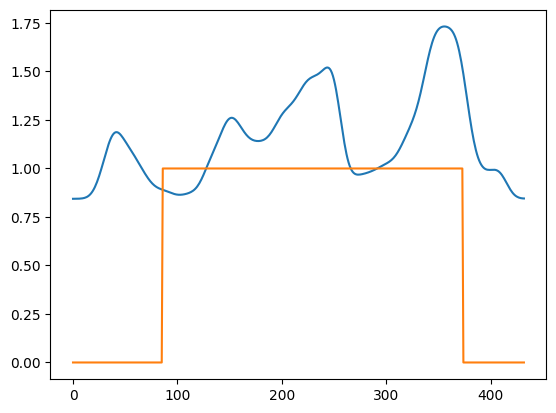

In [36]:
i=1
plt.plot(preds[i])
plt.plot(gts[i])

In [ ]:
roc_auc_score(gt,np.clip(_pred)

In [ ]:
np.clip(_pred,0,10)

In [22]:
np.mean(res1)
#0.65761537014756
#0.6645533892448818

#0.6480286128337436
#0.6480286128337436

0.8546205875441499

In [ ]:
i=0
for elem in train_loader:
    print(elem[0].detach().cpu().max())
    if i==500 :break
    i+=1
dt  = elem[0].permute(0,3,1,2)
model.to('cuda:0')
out = model(dt[:,:,:,:].float().to('cuda:0'))

In [ ]:
model.A[0]

In [ ]:
plt.imshow(elem[0][0,:,:,0].detach().cpu())

In [ ]:
plt.imshow(out[0][0,0,:,:].detach().cpu())

In [ ]:
out[0][0,0,:,:].detach().cpu()

In [ ]:
import torchvision
oo = out[0][:,:,:,:].detach().cpu()
ot = torchvision.transforms.Resize((32,32))(oo)

In [ ]:
ot.shape

In [ ]:
from gpec_models.gcae.gcae import Encoder
from gpec_models.fe.fe_model import init_fenet
model = init_fenet(None)

In [ ]:
model

In [ ]:
import torch
torch.resize()

In [ ]:
import torch
_dt   = torch.tensor(dt.transpose(2,0,1)[None],dtype=torch.float32).to('cuda:0')
model.train()
model = model.to('cuda:0')
out   = model(_dt)

In [ ]:
out[0][0].shape

In [ ]:
_t = dt
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(10,3))
axes[0].imshow(_t[:,:,0])
axes[1].imshow(_t[:,:,1])
axes[2].imshow(_t[:,:,2])

In [ ]:
_t = out[0][0].detach().cpu().numpy().transpose(1,2,0)
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(10,3))
axes[0].imshow(_t[:,:,0])
axes[1].imshow(_t[:,:,1])
axes[2].imshow(_t[:,:,2])

In [ ]:
dt,mtd = pg.__getitem__(786)
#_dt    = dt.transpose(1,2,0)
dt[:,:,0]-=dt[:,:,0].min()
dt[:,:,1]-=dt[:,:,1].min()
dt[:,:,0]/=dt[:,:,0].max()
dt[:,:,1]/=dt[:,:,1].max()
dt[:,:,2]/=dt[:,:,2].max()
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(10,4))
axes[0].imshow(dt[:,:,0])
axes[1].imshow(dt[:,:,1])
axes[2].imshow(dt[:,:,2])

In [ ]:
dt,mtd = pg.__getitem__(400)
#_dt    = dt.transpose(1,2,0)
dt[:,:,0]-=dt[:,:,0].min()
dt[:,:,1]-=dt[:,:,1].min()
dt[:,:,0]/=dt[:,:,0].max()
dt[:,:,1]/=dt[:,:,1].max()
dt[:,:,2]=0
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
axes[0].imshow(dt[:,:,0])
axes[1].imshow(dt[:,:,2])

In [ ]:
dt[:,:,2].max()

In [ ]:
dt.min()

In [ ]:
plot_pose(dt,mtd)

In [ ]:
size  = dt.max().astype('int32')
frame = np.zeros((size,size,3),dtype=np.uint8)

In [ ]:
vis_data(_dt)

In [ ]:
__dt[:,:,1].max()

In [ ]:
import argparse
import os.path as osp
import time
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GAE, VGAE, GCNConv

parser = argparse.ArgumentParser()
parser.add_argument('-f')
parser.add_argument('--variational', action='store_true')
parser.add_argument('--linear', action='store_true')
parser.add_argument('--dataset', type=str, default='Cora',
                    choices=['Cora', 'CiteSeer', 'PubMed'])
parser.add_argument('--epochs', type=int, default=400)
args = parser.parse_args()

if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      split_labels=True, add_negative_train_samples=False),
])
path = osp.join(osp.dirname(osp.realpath('.')), '..', 'data', 'Planetoid')
dataset = Planetoid(path, args.dataset, transform=transform)
train_data, val_data, test_data = dataset[0]


class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)


class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


class LinearEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        return self.conv(x, edge_index)


class VariationalLinearEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_mu = GCNConv(in_channels, out_channels)
        self.conv_logstd = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


in_channels, out_channels = dataset.num_features, 16

if not args.variational and not args.linear:
    model = GAE(GCNEncoder(in_channels, out_channels))
elif not args.variational and args.linear:
    model = GAE(LinearEncoder(in_channels, out_channels))
elif args.variational and not args.linear:
    model = VGAE(VariationalGCNEncoder(in_channels, out_channels))
elif args.variational and args.linear:
    model = VGAE(VariationalLinearEncoder(in_channels, out_channels))

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    loss = model.recon_loss(z, train_data.pos_edge_label_index)
    if args.variational:
        loss = loss + (1 / train_data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    return model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)


times = []
for epoch in range(1, args.epochs + 1):
    start = time.time()
    loss = train()
    auc, ap = test(test_data)
    print(f'Epoch: {epoch:03d}, AUC: {auc:.4f}, AP: {ap:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")